# Nanodomain detection

In [170]:
import numpy
import os, glob
import tifffile
import scikit_posthocs
import matplotlib
import io, pickle

from skimage import feature, filters, morphology, measure, restoration
from matplotlib import pyplot, patches
from collections import defaultdict
from scipy.ndimage import gaussian_filter
from scipy import optimize, stats
from skimage.transform import resize
from skimage.feature import peak_local_max
from tqdm.auto import tqdm

from metrics.detection import CentroidDetectionError

PATH = "./data/dataset/TAGAN"
files = glob.glob(os.path.join(PATH, "*.tif"))

In [171]:
def savefig(fig, ax, savepath, extension="pdf", save_white=False, **kwargs):
    """
    Utilitary function allowing to save the figure to 
    the savepath
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`  
    :param savepath: A `str` of the filename
    :param extension: A `str` of the extension of the file
    :param save_white: A `bool` wheter to save the figure in white version 
                       as well
    """
    dirname = os.path.dirname(savepath)
    basename = os.path.basename(savepath)    
    
    if not os.path.isdir(dirname):
        os.makedirs(dirname, exist_ok=True)
    
    fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True)
    if save_white:
        
        # Creates empty directory
        os.makedirs(os.path.join(dirname, "white"), exist_ok=True)
        savepath = os.path.join(dirname, "white", basename)

        buf = io.BytesIO()
        pickle.dump(fig, buf)
        buf.seek(0)
        fig = pickle.load(buf)
        
        change_figax_color(fig, ax, **kwargs)
        fig.savefig(f"{savepath}.{extension}", bbox_inches="tight", transparent=True, dpi=600)
        
        pyplot.close(fig)
        
def change_figax_color(fig, ax):
    """
    Utilitary function allowing to change the figure and 
    ax color from black to white
    
    :param fig: A `matplotlib.Figure`
    :param ax: A `matplotlib.Axes`    
    """
    def _change_ax(ax):
        ax.set_facecolor("none")
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('white')      
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        ax.title.set_color("white")
        
        # For line plots
        for line in ax.get_lines():
            if line.get_color() in ["#000000", "000000", "black"]:
                line.set_color("white")    

        # For scatter plots
        for collection in ax.collections:
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_facecolors()]
            new_colors = [mimic_white_alpha(c) for c in new_colors]
            collection.set_facecolors(new_colors)
            collection.set_alpha(1)
            new_colors = ["white" if matplotlib.colors.to_hex(c) == "#000000" else c 
                             for c in collection.get_edgecolors()] 
            new_colors = [mimic_white_alpha(c) for c in new_colors]            
            collection.set_edgecolors(new_colors)
            collection.set_alpha(1)            

        # For hist plots
        for patch in ax.patches:
            c = patch.get_facecolor()
            if matplotlib.colors.to_hex(c) == "#000000":
                patch.set_color("white")        
        
    # Change figure background
    fig.patch.set_facecolor("none")
    
    # Changes colorbars if any
    for ax in fig.axes:
        _change_ax(ax.axes)
        
def mimic_white_alpha(color):
    """
    Mimics the color that would be perceived of a color on a white 
    background
    
    :param color: A `matplotlib.collections` of lines
    
    :returns : A `list` of the colors
    """
    c_rgba = matplotlib.colors.to_rgba(color)
    c_rgb, alpha = c_rgba[:3], c_rgba[-1]
    return matplotlib.colors.to_hex(tuple(c * alpha + (1 - alpha) for c in c_rgb)) 


In [172]:
def gaussian(amplitude, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: amplitude * numpy.exp(
        -1 * (((center_x - x) ** 2.0 / (2 * width_x ** 2.0)) + ((center_y - y) ** 2.0 / (2 * width_y ** 2.0)))
    )

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    X, Y = numpy.indices(data.shape)
    X = X - numpy.max(X) / 2
    Y = Y - numpy.max(Y) / 2
    errorfunction = lambda p: numpy.ravel(gaussian(*p)(X, Y) - data)
    p, success = optimize.leastsq(errorfunction, [data.max(), 0, 0, 1, 1])
    
#     fig, ax = pyplot.subplots()
#     ax.imshow(gaussian(*p)(X, Y))
#     ax.set_title("optimized")
#     pyplot.show()
    
    return p


def find_nanodomains(acquired_signal, pixelsize, window_half_size=3, min_distance=2, threshold_rel=None):
    # first step is to find peaks in the image
    if isinstance(threshold_rel, float):
        guess_positions = peak_local_max(acquired_signal, min_distance=min_distance, threshold_rel=threshold_rel, exclude_border=True)
    else:
        threshold = filters.threshold_otsu(filters.gaussian(acquired_signal, sigma=3))
        foreground = filters.gaussian(sted, sigma=3) > threshold
        guess_positions = peak_local_max(acquired_signal, min_distance=min_distance, labels=foreground, exclude_border=True)

    padded_signal = numpy.pad(acquired_signal, window_half_size)

    # then we try to fit a gaussian on every identified peak. If one of its sigma is > 200 nm, we reject the guess
    valid_guesses = []
    for row, col in guess_positions:
        #TODO : what if the ND is on the edge of the image? I should test this :)
        data = padded_signal[(row + window_half_size) - window_half_size:
                             (row + window_half_size) + window_half_size + 1,
                             (col + window_half_size) - window_half_size:
                             (col + window_half_size) + window_half_size + 1]
#         data = data / data.max()
        
        params = fitgaussian(data)
        # fwhm is approx 2.355 * sigma, sigma_x is params[3], sigma_y is params[4]
        fwhm_x, fwhm_y = 2.355 * params[-2] * pixelsize, 2.355 * params[-1] * pixelsize
        if fwhm_x > 200e-9 or fwhm_x < 40e-9 or fwhm_y > 200e-9 or fwhm_y < 40e-9:
            pass
        else:
            valid_guesses.append((row, col))
    valid_guesses = numpy.asarray(valid_guesses)

    return valid_guesses

def find_nanodomains(img, sigma=1.0):
    filtered = filters.gaussian(img, sigma=sigma)
    threshold = numpy.quantile(filtered, 0.99)
    mask = filtered > threshold
    mask = morphology.remove_small_objects(mask, min_size=4, connectivity=2)
    labels = measure.label(mask)

    peaks = peak_local_max(filtered, min_distance=3, labels=labels, exclude_border=False)
    return peaks

In [207]:
## CONF
scores = ["f1_score", "precision", "recall"]
data_conf = defaultdict(list)
for file in tqdm(files):
    
    conf_file = file.replace("_fakeSTED.tif", "_CONF.tif").replace("/TAGAN", "")
    if '-2-_CONF' in conf_file:
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("_CONF", "_STED"))
        positions = numpy.load(conf_file.replace("_CONF.tif", "POSITIONS.npy"))

    #     peaks = peak_local_max(conf, min_distance=2, threshold_rel=0.6)
        peaks = find_nanodomains(conf)
        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }

        data_conf[len(positions)].append(output)

  0%|          | 0/480 [00:00<?, ?it/s]

In [208]:
## STED
scores = ["f1_score", "precision", "recall"]
data_sted = defaultdict(list)
for n, file in enumerate(tqdm(files)):
    conf_file = file.replace("_fakeSTED.tif", "_CONF.tif").replace("/TAGAN", "")
    if '-2-_CONF' in conf_file:
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("_CONF", "_STED"))
        positions = numpy.load(conf_file.replace("_CONF.tif", "POSITIONS.npy"))

        sigma = 0.5
    #     peaks = peak_local_max(filters.gaussian(sted, sigma=sigma), min_distance=2, threshold_rel=0.6)
        peaks = find_nanodomains(sted)

        if n < 10:
            fig, axes = pyplot.subplots(1, 2)

            filtered = filters.gaussian(sted, sigma=sigma)
            threshold = numpy.quantile(filtered, 0.99)
            mask = filtered > threshold
            mask = morphology.remove_small_objects(mask, min_size=4, connectivity=2)
            labels = measure.label(mask)

            peaks = peak_local_max(filtered, min_distance=3, labels=labels, exclude_border=False)

            axes[0].imshow(sted)

    #         peaks = peak_local_max(filters.gaussian(sted, sigma=0.5), min_distance=2, threshold_rel=0.6)

            axes[1].imshow(mask)
            if len(peaks) > 0:
                axes[1].scatter(peaks[:, 1], peaks[:, 0], color="orange")
            pyplot.show()    

        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }

        data_sted[len(positions)].append(output)

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

1 3


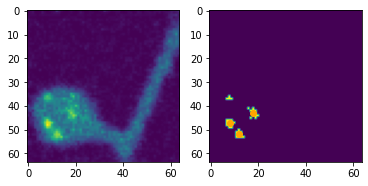

1 2


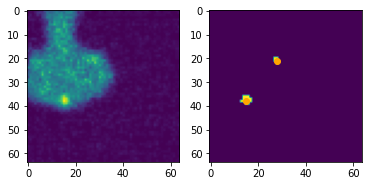

2 2


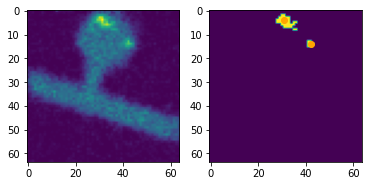

6 1
6 2
5 3
5 2
3 2
2 2
6 3
6 3
1 3
5 3
5 2
6 2
6 2
1 4
3 2
4 2
4 1
3 1
5 3
3 1
1 3
4 1
3 1
3 3
3 2
5 3
3 1
1 3
6 3
6 3
5 3
2 1
2 1
4 2
1 2
4 3
3 3
2 2
4 1
2 2
6 4
6 2
4 2
1 3
1 4
4 2
4 3
6 3
2 2
5 2
5 2
1 3
2 2
1 2
3 2
3 2
2 1
2 3
4 1
2 2
1 2
4 3
6 3
4 2
6 3
5 3
6 3
3 3
3 2
2 2
1 2
5 4
5 2
3 3
1 2
3 1
1 4
5 2
4 2
5 2
4 2
3 2
2 3
3 3
5 3
5 2
2 2
2 2
2 2
3 2
1 3
2 4
2 2
4 2
4 2
3 2
6 2
4 2
3 1
1 2
5 3
6 3
1 2
5 2
4 2
1 3
4 2
6 3
2 3
2 2
6 2
6 4
4 4
1 2
6 2
5 2
5 2


In [222]:
## TAGAN
scores = ["f1_score", "precision", "recall"]
data_fakeTAGAN = defaultdict(list)
for n, file in enumerate(tqdm(files)):
    conf_file = file.replace("_fakeSTED.tif", "_CONF.tif").replace("/TAGAN", "")
    if '-2-_CONF' in conf_file:
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("CONF", "STED"))
        fake = tifffile.imread(file).squeeze()
        positions = numpy.load(conf_file.replace("_CONF.tif", "POSITIONS.npy"))

        sigma = 0.5
    #     peaks = peak_local_max(filters.gaussian(fake, sigma=sigma), min_distance=2, threshold_rel=0.6)
        peaks = find_nanodomains(fake)    
    #     peaks = peak_local_max(fake, min_distance=3, threshold_rel=0.6)
        print(len(positions), len(peaks))

        if n < 10:
            fig, axes = pyplot.subplots(1, 2)

            filtered = filters.gaussian(fake, sigma=sigma)
            threshold = numpy.quantile(filtered, 0.99)
            mask = filtered > threshold
            mask = morphology.remove_small_objects(mask, min_size=4, connectivity=2)
            labels = measure.label(mask)

            axes[0].imshow(filtered)
            axes[1].imshow(mask)
            if len(peaks) > 0:
                axes[1].scatter(peaks[:, 1], peaks[:, 0], color="orange")
            pyplot.show()    


        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }

        data_fakeTAGAN[len(positions)].append(output)

  0%|          | 0/480 [00:00<?, ?it/s]

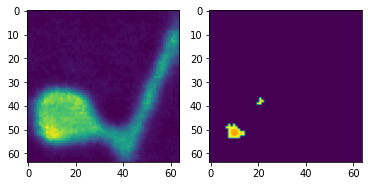

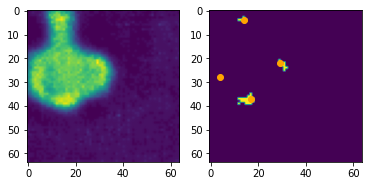

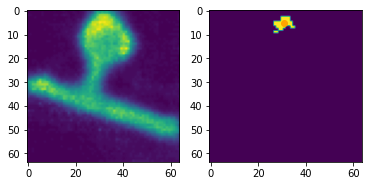

In [223]:
## PIX2PIX
scores = ["f1_score", "precision", "recall"]
data_fakePIX2PIX = defaultdict(list)
for n, file in enumerate(tqdm(files)):
    conf_file = file.replace("_fakeSTED.tif", "_CONF.tif").replace("/TAGAN", "")
    if '-2-_CONF' in conf_file:
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("CONF", "STED"))
        fake = tifffile.imread(file.replace("TAGAN/", "PIX2PIX/")).squeeze()
        positions = numpy.load(conf_file.replace("_CONF.tif", "POSITIONS.npy"))

        sigma = 0.5
    #     peaks = peak_local_max(filters.gaussian(fake, sigma=sigma), min_distance=2, threshold_rel=0.6)
        peaks = find_nanodomains(fake)    
    #     peaks = peak_local_max(fake, min_distance=3, threshold_rel=0.6)

        if n < 10:
            fig, axes = pyplot.subplots(1, 2)

            filtered = filters.gaussian(fake, sigma=sigma)
            threshold = numpy.quantile(filtered, 0.99)
            mask = filtered > threshold
            mask = morphology.remove_small_objects(mask, min_size=4, connectivity=2)
            labels = measure.label(mask)

            axes[0].imshow(filtered)
            axes[1].imshow(mask)
            if len(peaks) > 0:
                axes[1].scatter(peaks[:, 1], peaks[:, 0], color="orange")
            pyplot.show()    


        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }

        data_fakePIX2PIX[len(positions)].append(output)

  0%|          | 0/480 [00:00<?, ?it/s]

1 3


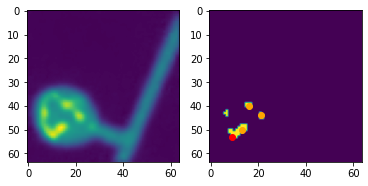

1 4


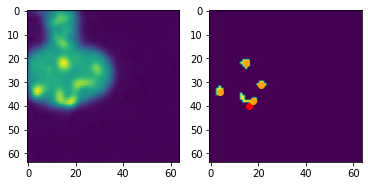

2 3


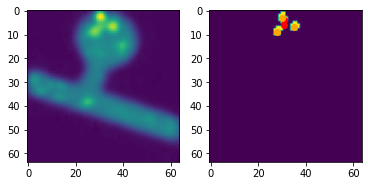

6 2
6 2
5 3
5 1
3 3
2 2
6 4
6 1
1 2
5 4
5 2
6 2
6 2
1 3
3 2
4 3
4 1
3 2
5 2
3 2
1 2
4 1
3 1
3 3
3 3
5 3
3 2
1 3
6 2
6 3
5 2
2 2
2 1
4 3
1 2
4 2
3 2
2 2
4 2
2 2
6 5
6 1
4 1
1 3
1 3
4 1
4 1
6 3
2 3
5 3
5 2
1 4
2 2
1 4
3 2
3 1
2 3
2 3
4 1
2 3
1 3
4 4
6 3
4 2
6 1
5 3
6 3
3 2
3 3
2 1
1 4
5 3
5 2
3 3
1 3
3 3
1 4
5 3
4 2
5 3
4 2
3 3
2 3
3 2
5 1
5 3
2 1
2 1
2 3
3 1
1 5
2 2
2 2
4 2
4 2
3 3
6 2
4 1
3 2
1 5
5 2
6 2
1 3
5 2
4 1
1 3
4 3
6 2
2 1
2 1
6 1
6 3
4 2
1 2
6 1
5 1
5 1


In [224]:
## CARE
scores = ["f1_score", "precision", "recall"]
data_fakeCARE = defaultdict(list)
for n, file in enumerate(tqdm(files)):
    conf_file = file.replace("_fakeSTED.tif", "_CONF.tif").replace("/TAGAN", "")
    if '-2-_CONF' in conf_file:
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("CONF", "STED"))
    #     fake = tifffile.imread(file).squeeze()
        fake = file.replace("_fakeSTED.tif", "_result.tif")
        fake = tifffile.imread(fake.replace("TAGAN/", "CARE/"))
        positions = numpy.load(conf_file.replace("_CONF.tif", "POSITIONS.npy"))

        sigma = 0.5
    #     peaks = peak_local_max(filters.gaussian(fake, sigma=sigma), min_distance=2, threshold_rel=0.6)
        peaks = find_nanodomains(fake)
        print(len(positions), len(peaks))
    #     peaks = peak_local_max(fake, min_distance=3, threshold_rel=0.6)

        if n < 10:
            fig, axes = pyplot.subplots(1, 2)

            filtered = filters.gaussian(fake, sigma=sigma)
            threshold = numpy.quantile(filtered, 0.99)
            mask = filtered > threshold
            mask = morphology.remove_small_objects(mask, min_size=4, connectivity=2)
            labels = measure.label(mask)

            axes[0].imshow(filtered)
            axes[1].imshow(mask)
            axes[1].scatter(positions[:, 1], positions[:, 0], color="red")
            if len(peaks) > 0:
                axes[1].scatter(peaks[:, 1], peaks[:, 0], color="orange")
            pyplot.show()    


        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }

        data_fakeCARE[len(positions)].append(output)

In [220]:
### ESRGAN
scores = ["f1_score", "precision", "recall"]
data_fakeESRGAN = defaultdict(list)
for n, file in enumerate(tqdm(files)):
    conf_file = file.replace("_fakeSTED.tif", "_CONF.tif").replace("/TAGAN", "")
    if '-5-_CONF' in conf_file:
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("CONF", "STED"))
    #     fake = tifffile.imread(file).squeeze()
        fake = file.replace("_fakeSTED.tif", "_out_net_g_50000.pth.tif")
        fake = tifffile.imread(fake.replace("TAGAN/", "ESRGAN/"))
        positions = numpy.load(conf_file.replace("_CONF.tif", "POSITIONS.npy"))

        sigma = 0.5
    #     peaks = peak_local_max(filters.gaussian(fake, sigma=sigma), min_distance=2, threshold_rel=0.6)
        peaks = find_nanodomains(fake)    
    #     peaks = peak_local_max(fake, min_distance=3, threshold_rel=0.6)
        print(len(positions), len(peaks))

        if n < 10:
            fig, axes = pyplot.subplots(1, 2)

            filtered = filters.gaussian(fake, sigma=sigma)
            threshold = numpy.quantile(filtered, 0.99)
            mask = filtered > threshold
            mask = morphology.remove_small_objects(mask, min_size=4, connectivity=2)
            labels = measure.label(mask)

            axes[0].imshow(filtered)
            axes[1].imshow(mask)
            axes[1].scatter(positions[:, 1], positions[:, 0], color="red")
            if len(peaks) > 0:
                axes[1].scatter(peaks[:, 1], peaks[:, 0], color="orange")
            pyplot.show()    


        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }

        data_fakeESRGAN[len(positions)].append(output)

  0%|          | 0/480 [00:00<?, ?it/s]

3 21
2 22
4 17
6 18
2 14
2 20
2 18
2 22
3 29
1 26
5 15
5 21
4 17
1 26
1 23
2 17
5 19
6 22
1 29
3 15
1 26
4 18
6 20
3 20
1 20
5 22
4 19
4 18
4 18
1 25
2 13
4 18
4 16
3 19
1 27
3 14
6 20
6 21
5 16
1 21
6 24
1 17
6 17
3 15
1 15
2 21
4 23
3 22
3 18
6 18
4 18
2 22
3 18
4 13
2 26
6 17
6 16
5 19
3 24
5 17
4 19
5 21
5 16
5 19
5 22
4 19
5 17
2 15
6 14
3 19
3 34
6 23
5 20
2 17
4 19
1 20
6 19
6 15
1 24
5 18
6 16
2 12
2 15
4 18
5 18
3 15
2 17
3 20
2 15
4 16
1 44
2 21
1 31
5 20
3 19
4 19
5 21
3 22
1 21
4 23
6 12
5 18
1 19
4 21
3 19
6 21
4 16
6 15
1 21
2 19
3 19
6 21
2 12
3 18
6 13
2 25
1 21
1 18
5 21
5 24


In [221]:
### RCAN
scores = ["f1_score", "precision", "recall"]
data_fakeRCAN = defaultdict(list)
for n, file in enumerate(tqdm(files)):
    conf_file = file.replace("_fakeSTED.tif", "_CONF.tif").replace("/TAGAN", "")
    if '-5-_CONF' in conf_file:
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("CONF", "STED"))
    #     fake = tifffile.imread(file).squeeze()
        fake = file.replace("_fakeSTED.tif", ".tif")
        fake = tifffile.imread(fake.replace("TAGAN/", "RCAN/"))[1]
        positions = numpy.load(conf_file.replace("_CONF.tif", "POSITIONS.npy"))

        sigma = 0.5
    #     peaks = peak_local_max(filters.gaussian(fake, sigma=sigma), min_distance=2, threshold_rel=0.6)
        peaks = find_nanodomains(fake)    
    #     peaks = peak_local_max(fake, min_distance=3, threshold_rel=0.6)
        print(len(positions), len(peaks))

        if n < 10:
            fig, axes = pyplot.subplots(1, 2)

            filtered = filters.gaussian(fake, sigma=sigma)
            threshold = numpy.quantile(filtered, 0.99)
            mask = filtered > threshold
            mask = morphology.remove_small_objects(mask, min_size=4, connectivity=2)
            labels = measure.label(mask)

            axes[0].imshow(filtered)
            axes[1].imshow(mask)
            axes[1].scatter(positions[:, 1], positions[:, 0], color="red")
            if len(peaks) > 0:
                axes[1].scatter(peaks[:, 1], peaks[:, 0], color="orange")
            pyplot.show()    


        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }

        data_fakeRCAN[len(positions)].append(output)

  0%|          | 0/480 [00:00<?, ?it/s]

3 2
2 2
4 3
6 2
2 1
2 2
2 2
2 2
3 2
1 1
5 2
5 2
4 2
1 1
1 1
2 2
5 2
6 3
1 1
3 1
1 1
4 3
6 3
3 3
1 1
5 2
4 1
4 2
4 3
1 1
2 2
4 3
4 2
3 1
1 1
3 2
6 2
6 2
5 3
1 1
6 4
1 2
6 3
3 2
1 1
2 2
4 3
3 2
3 2
6 3
4 3
2 2
3 2
4 2
2 2
6 2
6 3
5 2
3 1
5 3
4 3
5 2
5 2
5 3
5 2
4 3
5 2
2 2
6 2
3 1
3 3
6 2
5 2
2 1
4 4
1 2
6 3
6 3
1 2
5 3
6 3
2 1
2 1
4 3
5 1
3 2
2 1
3 2
2 2
4 2
1 1
2 2
1 1
5 3
3 2
4 3
5 4
3 3
1 2
4 2
6 3
5 2
1 1
4 2
3 1
6 3
4 2
6 2
1 1
2 2
3 2
6 4
2 1
3 2
6 2
2 2
1 1
1 1
5 3
5 3


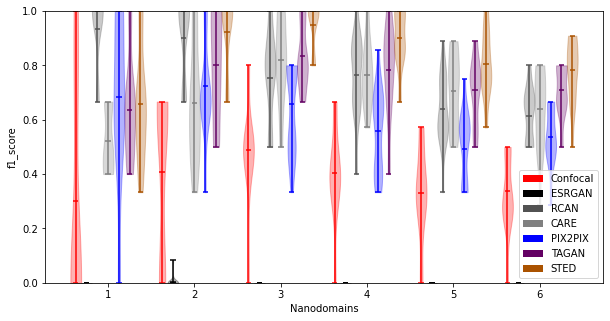

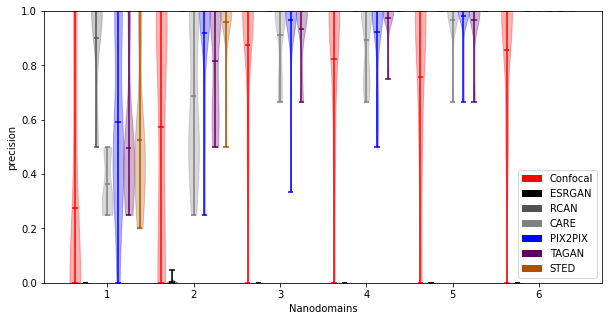

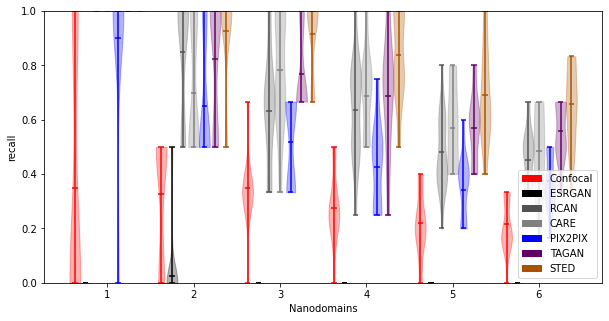

In [214]:
COLORS = ["#ff0000", "#000000", "#525252", "#808080", "#0000ff", "#630063", "#aa5200"]
width = 1 / (len(COLORS) + 1)
for score in scores:
    fig, ax = pyplot.subplots(figsize=(10,5))
    for n, data in enumerate((data_conf, data_fakeESRGAN, data_fakeRCAN, data_fakeCARE, data_fakePIX2PIX, data_fakeTAGAN, data_sted)):
        for key, values in data.items():
            ys = [value[score] for value in values]
            parts = ax.violinplot(
                ys, positions=[int(key) + width * n], widths=width, showmeans=True
            )
            for key, values in parts.items():
                if key == "bodies":
                    for value in values:
                        value.set_facecolor(COLORS[n])
                        value.set_edgecolor(COLORS[n])
                        value.set_alpha(0.3)
                else:
                    values.set_color(COLORS[n])
            
    ax.set(
        ylabel=score, ylim=(0, 1),
        xlabel="Nanodomains", 
        xticks=numpy.arange(len(data_conf)) + 1 + (len(COLORS) - 1) * width / 2, 
        xticklabels=numpy.arange(len(data_conf)) + 1
    )
    ax.legend(
        handles=[patches.Patch(facecolor=c) for c in COLORS],
        labels=["Confocal", "ESRGAN", "RCAN", "CARE", "PIX2PIX", "TAGAN", "STED"],
        loc="lower right"
    )
pyplot.show()

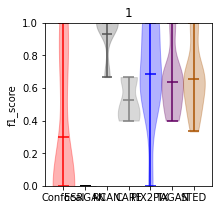

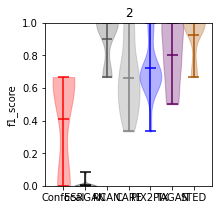

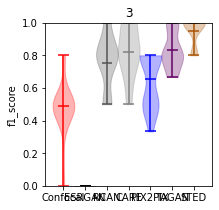

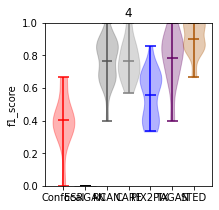

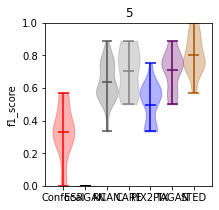

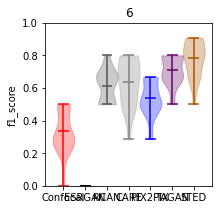

In [215]:
width = 1 / (len(COLORS) + 1)

for score in scores[:1]:
    figaxes = {key : pyplot.subplots(figsize=(3,3)) for key in sorted(data_sted.keys(), key=lambda x : int(x))}
    for n, data in enumerate((data_conf, data_fakeESRGAN, data_fakeRCAN, data_fakeCARE, data_fakePIX2PIX, data_fakeTAGAN, data_sted)):
        for key, values in data.items():
            ys = [value[score] for value in values]
            
            fig, ax = figaxes[key]
            parts = ax.violinplot(
                ys, positions=[width * n], widths=width, showmeans=True
            )
            for key, values in parts.items():
                if key == "bodies":
                    for value in values:
                        value.set_facecolor(COLORS[n])
                        value.set_edgecolor(COLORS[n])
                        value.set_alpha(0.3)
                else:
                    values.set_color(COLORS[n])
                    
    for key, (fig, ax) in figaxes.items():
        ax.set(
            title=key, ylim=(0, 1),
            ylabel=score, 
            xticks=numpy.arange(len(COLORS)) * width, xticklabels=["Confocal", "ESRGAN", "RCAN", "CARE", "PIX2PIX", "TAGAN", "STED"]
        )
        savefig(fig, ax, f"./panels/f1-score/{key}", save_white=True)
    pyplot.show()

## Statistics

In [195]:
def fit_model(data):
    """
    This function implements the linear model for the one-way ANOVA.

    :param data: A list of list of each observations in each treatments

    :returns : The fitted model, the residuals, the standardize residuals and
               the quantiles for probability plot

    Ref : https://onlinelibrary.wiley.com/doi/full/10.1111/jac.12220
    """
    fitted, residuals, standard_residuals, quantiles = [],[],[],[]
    for treatment in data:
        treatment = numpy.array(treatment)
        mean = numpy.mean(treatment)
        fitted.append(mean)
        residuals.append(treatment - mean)
        sr = (treatment - mean) / numpy.std(treatment)
        standard_residuals.append(sr)
        quantiles.append(stats.probplot(sr, dist="norm", fit=True))
    return fitted, residuals, standard_residuals, quantiles


def verify_normality(samples, alpha=0.05):
    """
    Verifies the normality of the data
    """
    # print([stats.shapiro(sample)[1] for sample in samples])
    return [stats.shapiro(sample)[1] > alpha for sample in samples]


def get_significance(samples, labels=None, show_qq=False, force_normal_test=False, show_sr=False, verbose=False):
    """
    Computes a statistic analysis of the given samples.
    :param samples: A list of sample observations
    :param show_qq: Wheter to show the quantiles
    :param force_normal_test: Wheter to force the normal test
    :param show_sr: Wheter to show standard residuals
    :param verbose: Wheter to use verbose
    """
    _print = print if verbose else lambda *args, **kwargs : None # Defines the level of verbosity
    fitted, residuals, standard_res, quantiles = fit_model(samples)
    if show_qq:
        fig, ax = pyplot.subplots()
        for params, fit in quantiles:
            ax.scatter(params[0], params[1], facecolor="white", edgecolor="black")
        lims = [
            numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
        ]
        ax.plot(lims, lims, color="gray", linestyle="dashed")
        ax.set_title("QQ-Plot")
    if show_sr:
        fig, ax = pyplot.subplots()
        ax.boxplot(standard_res)

    # print([fit[2] for params, fit in quantiles])
    # normality = all([fit[2] > 0.9 for params, fit in quantiles])
    normality = all(verify_normality(standard_res))
    if normality or force_normal_test :
        _print("The standardize residuals are normaly distributed.")
        statistic, pvalue = stats.f_oneway(*samples)
        if pvalue > 0.05:
            _print("The one-way ANOVA test that two or more groups have the same " +
            "population mean cannot be rejected with alpha confidence of 0.05.\n" +
            "\tpvalue : {}".format(pvalue))
            pvalues = numpy.ones((len(samples), len(samples)))
        else:
            _print("The null hypothesis can be rejected from the ANOVA one way test.\n"+
                    "\tpvalue : {}".format(pvalue))
            _print("Posthoc ttest is computed on the data")
            pvalues = scikit_posthocs.posthoc_ttest(samples)
            _print("Posthoc t-test results\n" +
                    "\tpvalues : {}".format(pvalues))
    else :
        _print("The standardize residuals are not normaly distributed.")
        statistics, pvalue = stats.kruskal(*samples)
        if pvalue > 0.05:
            _print("The null hypothesis cannot be rejected from the Kruskal-Wallis H-test.")
            pvalues = numpy.ones((len(samples), len(samples)))
        else:
            _print("The null hypothesis can be rejected from the Kruskal-Wallis H-test.\n"+
                    "\tpvalue : {}".format(pvalue))
            _print("Posthoc Dunn is computed on the data.")
            pvalues = scikit_posthocs.posthoc_dunn(samples)
    
    if isinstance(labels, list):
        pvalues.index = labels
        pvalues.columns = labels
    
    combinations = [(i, j) for i in range(len(samples)) for j in range(i + 1, len(samples))]
    significance = []
    for (i, j) in combinations:
        pvalue = pvalues.iloc[i, j]
        if pvalue <= 0.001:
            significance.append((pvalue, 3, i, j))
        elif pvalue <= 0.01:
            significance.append((pvalue, 2, i, j))
        elif pvalue <= 0.05:
            significance.append((pvalue, 1, i, j))
        else:
            significance.append((pvalue, 0, i, j))
    return significance, pvalues

/tmp/ipykernel_5613/4101981772.py:18: RuntimeWarning: invalid value encountered in true_divide
  sr = (treatment - mean) / numpy.std(treatment)


The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 4.411057018124888e-14
Posthoc Dunn is computed on the data.


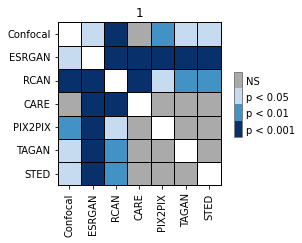

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 3.201022554945767e-16
Posthoc Dunn is computed on the data.


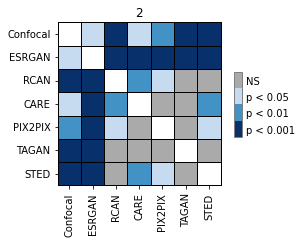

/tmp/ipykernel_5613/4101981772.py:18: RuntimeWarning: invalid value encountered in true_divide
  sr = (treatment - mean) / numpy.std(treatment)


The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 1.4127539671974256e-18
Posthoc Dunn is computed on the data.


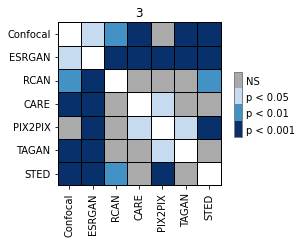

/tmp/ipykernel_5613/4101981772.py:18: RuntimeWarning: invalid value encountered in true_divide
  sr = (treatment - mean) / numpy.std(treatment)


The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 1.7797007227307655e-19
Posthoc Dunn is computed on the data.


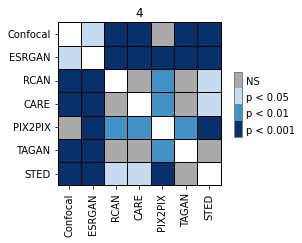

/tmp/ipykernel_5613/4101981772.py:18: RuntimeWarning: invalid value encountered in true_divide
  sr = (treatment - mean) / numpy.std(treatment)


The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 2.0651629493343746e-19
Posthoc Dunn is computed on the data.


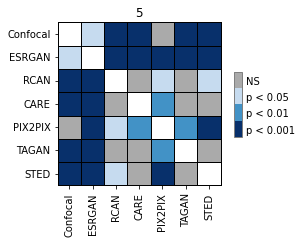

/tmp/ipykernel_5613/4101981772.py:18: RuntimeWarning: invalid value encountered in true_divide
  sr = (treatment - mean) / numpy.std(treatment)


The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 8.39963663137597e-20
Posthoc Dunn is computed on the data.


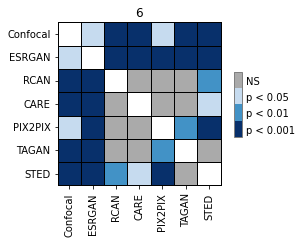

In [216]:
labels = ["Confocal", "ESRGAN", "RCAN", "CARE", "PIX2PIX", "TAGAN", "STED"]
for key in sorted(data_sted.keys(), key=lambda x : int(x)):
    samples = []
    for data in [data_conf, data_fakeESRGAN, data_fakeRCAN, data_fakeCARE, data_fakePIX2PIX, data_fakeTAGAN, data_sted]:
        sample = [value["f1_score"] for value in data[key]]
        samples.append(sample)
        
    significance, pvalues = get_significance(samples, labels=labels, show_qq=False, show_sr=False, verbose=True)
    fig, ax = pyplot.subplots(figsize=(3,3))
    cmap = ['1', '#aaaaaa',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {
        'cmap': cmap, 'linewidths': 1.0, 'linecolor': '0.', 
        'clip_on': False, 'square': True, 
    #     'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3],
    }
    scikit_posthocs.sign_plot(pvalues, ax=ax, **heatmap_args)
    ax.set_title(key)
    
    savefig(fig, ax, f"./panels/f1-score/stats/{key}", save_white=True)

    pyplot.show()

# Deconvolution

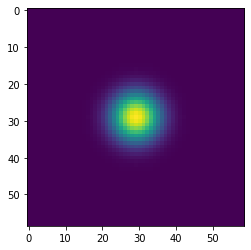

  0%|          | 0/120 [00:00<?, ?it/s]

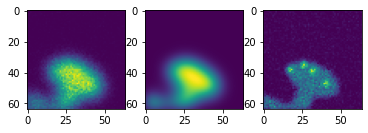

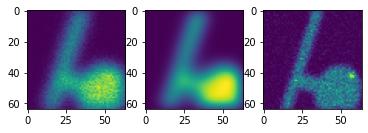

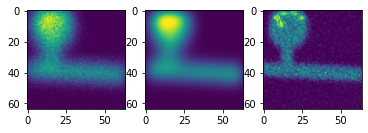

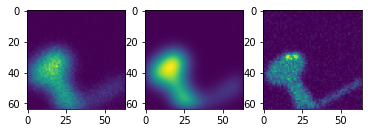

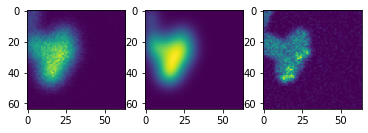

  0%|          | 0/120 [00:00<?, ?it/s]

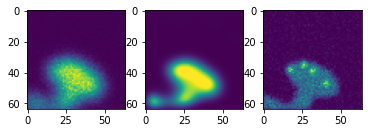

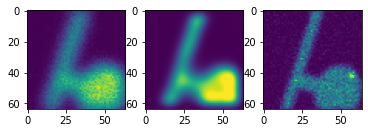

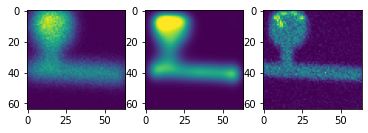

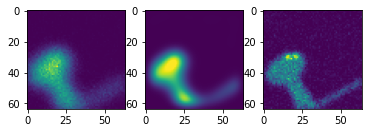

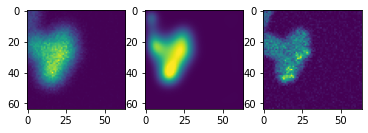

  0%|          | 0/120 [00:00<?, ?it/s]

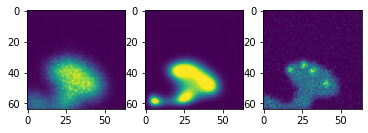

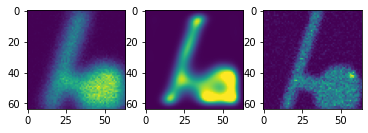

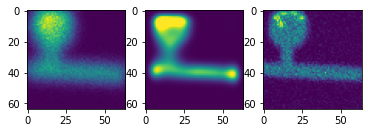

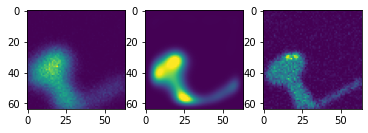

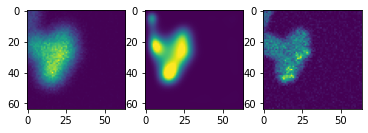

  0%|          | 0/120 [00:00<?, ?it/s]

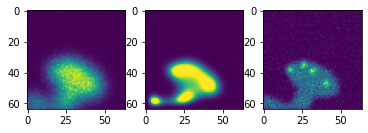

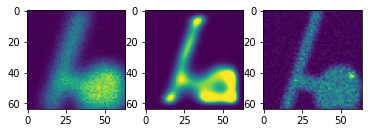

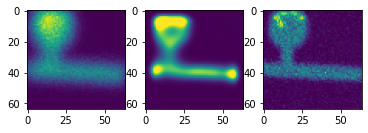

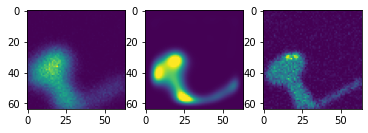

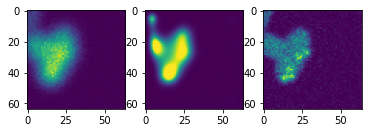

  0%|          | 0/120 [00:00<?, ?it/s]

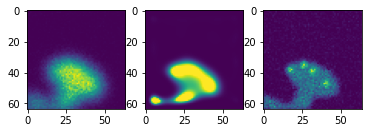

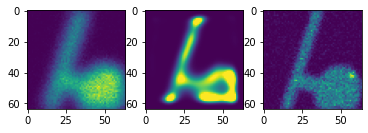

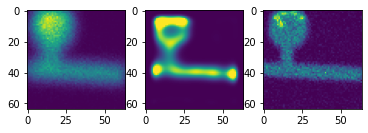

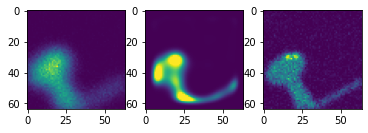

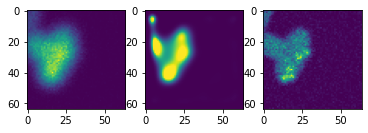

In [578]:

PATH = "../data/dataset"
effective_sted = numpy.load(os.path.join(PATH, "effective-STED.npy"))
effective_conf = numpy.load(os.path.join(PATH, "effective-CONF.npy"))

center = effective_conf.shape[0] // 2
# psf = effective_conf[center - half_width : center + half_width + 1, center - half_width : center + half_width + 1]
psf = effective_conf
psf = (psf - psf.min()) / (psf.max() - psf.min())
psf = psf / psf.sum()

fig, ax= pyplot.subplots()
ax.imshow(psf)
pyplot.show()

scores = ["f1_score", "precision", "recall"]
all_data = [data_conf]
num_iters = [2, 5, 10, 15, 30]
for num_iter in num_iters:
    data_deconv = defaultdict(list)
    for n, file in enumerate(tqdm(files)):
        conf_file = file.replace("_fakeSTED.tif", "CONF.tif").replace("/fake", "")
        conf = tifffile.imread(conf_file)
        sted = tifffile.imread(conf_file.replace("CONF", "STED"))
        fake = tifffile.imread(file).squeeze()
        positions = numpy.load(conf_file.replace("CONF.tif", "POSITIONS.npy"))

        deconvolved = restoration.richardson_lucy(conf / conf.max(), psf=psf, num_iter=num_iter)

        if n < 5:
            fig, axes = pyplot.subplots(1, 3)
            axes[0].imshow(conf)
            axes[1].imshow(deconvolved)
            axes[2].imshow(sted)
            pyplot.show()

        peaks = find_nanodomains(deconvolved)
        detection_error = CentroidDetectionError(positions, peaks, threshold=5)
        output = {
            "file" : file,
            **{score : getattr(detection_error, score) for score in scores}
        }            
            
        data_deconv[len(positions)].append(output)
    all_data.append(data_deconv)

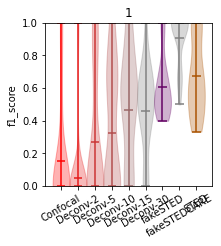

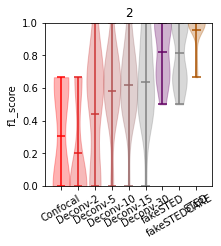

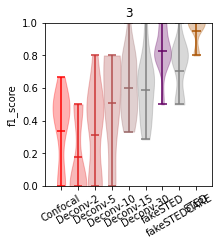

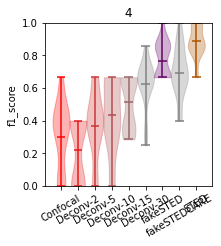

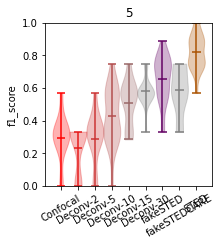

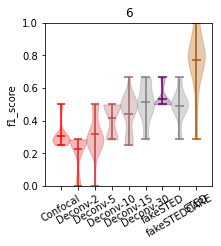

In [580]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name = "blue",
    colors = ["#ff0000", "tab:grey"],
    N = len(num_iters) + 1
)
COLORS = [*[cmap(i) for i in range(len(num_iters) + 1)], "#630063", "tab:grey", "#aa5200"]
labels = ["Confocal", *[f"Deconv-{n}" for n in num_iters], "fakeSTED", "fakeSTEDCARE", "STED"]
width = 1 / (len(COLORS) + 1)

for score in scores[:1]:
    figaxes = {key : pyplot.subplots(figsize=(3,3)) for key in sorted(data_conf.keys(), key=lambda x : int(x))}
    for n, data in enumerate(all_data + [data_fake, data_fakeCARE, data_sted]):
        for key, values in data.items():
            ys = [value[score] for value in values]
            fig, ax = figaxes[key]
            parts = ax.violinplot(
                ys, positions=[width * n], widths=width, showmeans=True
            )
            for key, values in parts.items():
                if key == "bodies":
                    for value in values:
                        value.set_facecolor(COLORS[n])
                        value.set_edgecolor(COLORS[n])
                        value.set_alpha(0.3)
                else:
                    values.set_color(COLORS[n])
                    
    for key, (fig, ax) in figaxes.items():
        ax.set(
            title=key, ylim=(0, 1),
            ylabel=score, 
            xticks=numpy.arange(len(COLORS)) * width
        )
        ax.set_xticklabels(labels, rotation=30)
        
        savefig(fig, ax, f"./panels/f1-score/{key}", save_white=True)
        
    pyplot.show()

## Stats

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 7.847144669485275e-13
Posthoc Dunn is computed on the data.


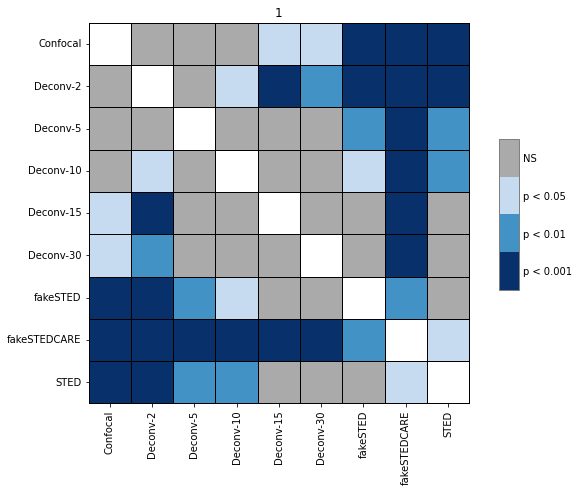

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 3.309233827532779e-14
Posthoc Dunn is computed on the data.


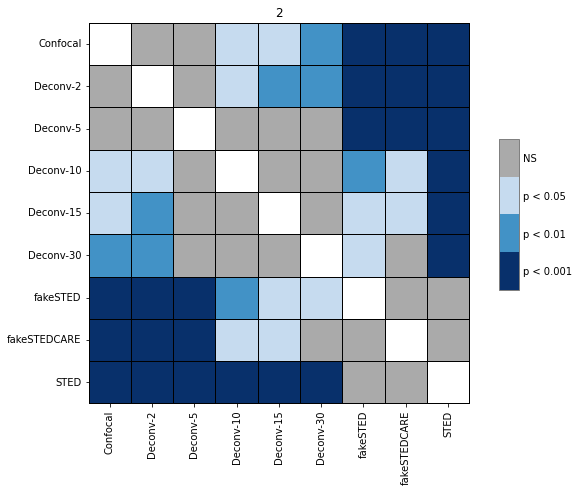

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 4.746950335315851e-19
Posthoc Dunn is computed on the data.


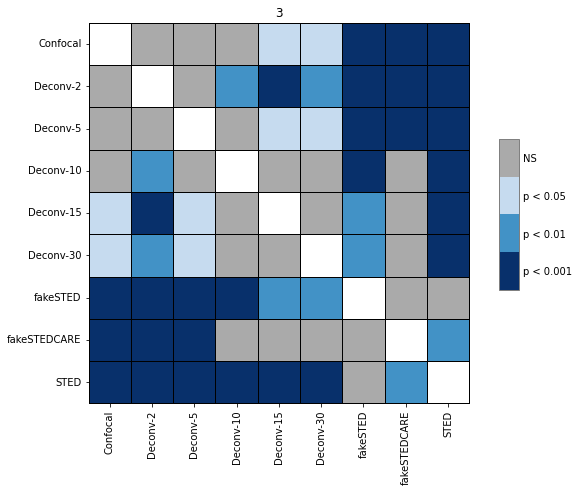

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 3.839286901540671e-20
Posthoc Dunn is computed on the data.


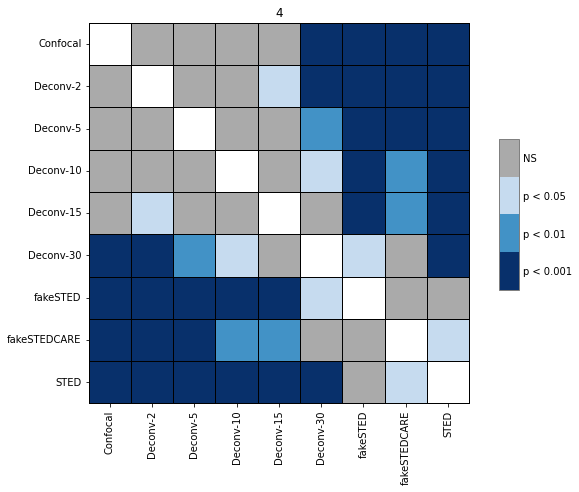

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 2.9938123827915666e-21
Posthoc Dunn is computed on the data.


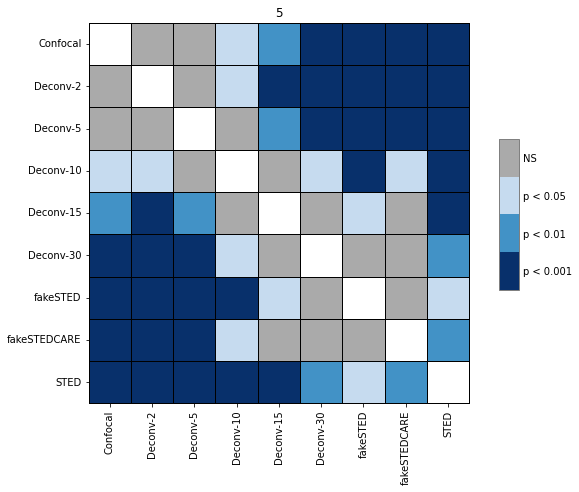

The standardize residuals are not normaly distributed.
The null hypothesis can be rejected from the Kruskal-Wallis H-test.
	pvalue : 5.018675636228666e-20
Posthoc Dunn is computed on the data.


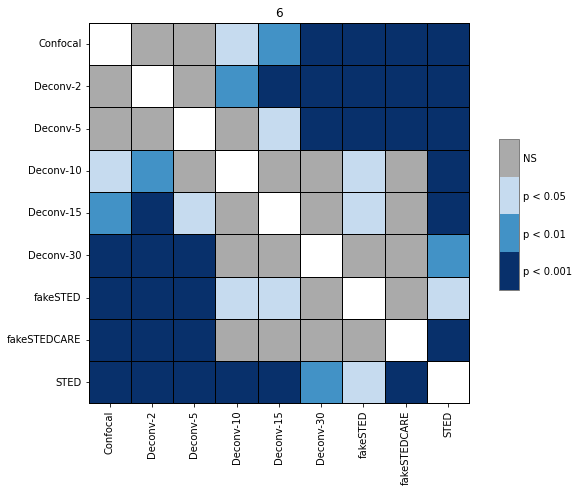

In [582]:
for key in sorted(data_conf.keys(), key=lambda x : int(x)):
    samples = []
    for data in [*all_data, data_fake, data_fakeCARE, data_sted]:
        sample = [value["f1_score"] for value in data[key]]
        samples.append(sample)
        
    significance, pvalues = get_significance(samples, labels=labels, show_qq=False, show_sr=False, verbose=True)
    fig, ax = pyplot.subplots(figsize=(7,7))
    cmap = ['1', '#aaaaaa',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {
        'cmap': cmap, 'linewidths': 1.0, 'linecolor': '0.', 
        'clip_on': False, 'square': True, 
    #     'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3],
    }
    scikit_posthocs.sign_plot(pvalues, ax=ax, **heatmap_args)
    ax.set_title(key)

    savefig(fig, ax, f"./panels/f1-score/stats/{key}", save_white=True)

    pyplot.show()